# Blood biomarkers of diabetogenic vs. antidiabetogenic obesity subtypes

## Background

- Obesity is closely linked to T2D.
- However, this relationship is heterogeneous.
    - ~15% of people with T2D are lean.
    - ~30% of poeple with obesity have a profile that seems to be protective against T2D.
    - ~30% of people with normal weight develop T2D[<sup>1</sup>](https://dx.doi.org/10.1161%2FCIRCRESAHA.115.306825)
- T2D is in turn, a life-threatening condition, linked to many cardiovascular diseases.
- Better risk stratification and tailored interventions can potentially improve outcomes in obesity.

## Aims

- Use genetics to stratify obesity into subtypes that are:
    - __Concordant__ $\longrightarrow$ Associated with higher T2D risk.
    - __Discordant__ $\longrightarrow$ Associated with lower T2D risk.

- Identify differences in blood biomarkers between the two subtypes.

## Analysis pipeline

#### Libraries to use:

In [397]:
import re # To modify strings
import pandas as pd # For data wrangling
import numpy as np # For numeric operations
import matplotlib.pyplot as plt # For plotting
import seaborn as sns

### 1. Data download

Download of genome-wide association statistics:

1.1. For BMI - results from Yengo et al. [<sup>2</sup>](https://doi.org/10.1093/hmg/ddy271)

In [136]:
bmi_url = ('https://portals.broadinstitute.org/collaboration/giant/images/c/c8/' + 
           'Meta-analysis_Locke_et_al%2BUKBiobank_2018_UPDATED.txt.gz')
!curl -s $bmi_url | gunzip > bmi.txt

In [137]:
!head bmi.txt

CHR	POS	SNP	Tested_Allele	Other_Allele	Freq_Tested_Allele_in_HRS	BETA	SE	P	N
7	92383888	rs10	A	C	0.06431	 0.0013	0.0042	 7.5e-01	598895
12	126890980	rs1000000	A	G	0.2219	 0.0001	0.0021	 9.6e-01	689928
4	21618674	rs10000010	T	C	0.5086	-0.0001	0.0016	 9.4e-01	785319
4	1357325	rs10000012	C	G	0.8634	 0.0047	0.0025	 5.7e-02	692463
4	37225069	rs10000013	A	C	0.7708	-0.0061	0.0021	 3.3e-03	687856
4	84778125	rs10000017	T	C	0.2284	 0.0041	0.0021	 4.8e-02	686123
3	183635768	rs1000002	T	C	0.4884	-0.0055	0.0017	 1.3e-03	692520
4	95733906	rs10000023	T	G	0.5817	-0.0047	0.0018	 7.2e-03	676691
4	156176217	rs10000027	C	G	0.771	-0.0013	0.0023	 5.7e-01	525093


1.2. For T2D -  results from Mahajan et al. [<sup>3</sup>](https://doi.org/10.1038/s41588-018-0241-6)

In [144]:
## Needs to send confirmation of terms of use
t2d_url = 'https://www.diagram-consortium.org/check_check.Mahajan2018b.T2D.3.php'
!curl -s --data "confirm=1" $t2d_url | tar -xf - -O 2>/dev/null > t2d.txt

In [145]:
!head t2d.txt

SNP	Chr	Pos	EA	NEA	EAF	Beta	SE	Pvalue	Neff
1:100000012	1	100000012	T	G	0.25	-0.026	0.0073	4.0e-04	231420
1:10000006	1	10000006	A	G	0.0047	-0.038	0.056	4.9e-01	225429
1:100000135	1	100000135	A	T	0.99	-0.033	0.055	5.5e-01	226311
1:100000436	1	100000436	T	C	1	-0.098	0.19	6.1e-01	185906
1:100000827	1	100000827	T	C	0.3	-0.023	0.0069	7.5e-04	231420
1:100000843	1	100000843	T	C	0.94	0.0006	0.014	9.7e-01	231420
1:100001138	1	100001138	A	G	0.97	-0.0041	0.022	8.6e-01	230619
1:100001201	1	100001201	T	G	0.1	-0.017	0.0099	8.9e-02	231420
1:100001233	1	100001233	T	C	1	-0.45	0.24	5.7e-02	171397


1.3. Reference panel -  1000 Genomes EUR[<sup>4</sup>](https://www.internationalgenome.org/). We will use a preprocessed version by the University of Bristol[<sup>5</sup>](https://mrcieu.github.io/gwasvcf/)

In [ ]:
!curl -s -o ref1kg.tgz http://fileserve.mrcieu.ac.uk/ld/1kg.v3.tgz

In [316]:
!tar -xf ref1kg.tgz EUR.bed EUR.bim EUR.fam

### 2. Cross-referencing genetic associations for BMI and T2D

2.3. Join BMI and T2D datasets using their reported genomic position, both mapped to genome build _hg19_.

In [272]:
!awk 'NR==FNR{a[$1":"$2]=$0;next} $1 in a {print a[$1], "\t", $0}' bmi.txt t2d.txt > bmi_t2d.txt

In [275]:
!head bmi_t2d.txt

1	100000012	rs10875231	T	G	0.2409	 0.0022	0.0020	 2.8e-01	691586 	 1:100000012	1	100000012	T	G	0.25	-0.026	0.0073	4.0e-04	231420
1	100000827	rs6678176	T	C	0.3006	 0.0027	0.0019	 1.5e-01	692276 	 1:100000827	1	100000827	T	C	0.3	-0.023	0.0069	7.5e-04	231420
1	100005477	rs12069019	A	G	0.1407	 0.0062	0.0025	 1.3e-02	692441 	 1:100005477	1	100005477	A	G	0.14	-0.024	0.0092	8.5e-03	231420
1	100006117	rs6686057	A	G	0.4196	-0.0013	0.0018	 4.6e-01	689671 	 1:100006117	1	100006117	A	G	0.42	0.0078	0.0065	2.3e-01	231420
1	100007454	rs12082355	T	C	0.14	 0.0063	0.0025	 1.2e-02	692408 	 1:100007454	1	100007454	T	C	0.14	-0.024	0.0092	8.2e-03	231420
1	100008607	rs11166268	A	C	0.7001	-0.0027	0.0019	 1.6e-01	692445 	 1:100008607	1	100008607	A	C	0.7	0.023	0.0069	8.8e-04	231420
1	100010434	rs12130109	A	G	0.1004	-0.0037	0.0028	 1.9e-01	680530 	 1:100010434	1	100010434	A	G	0.11	-0.018	0.01	6.9e-02	231420
1	100010765	rs1416885	C	G	0.7004	-0.0026	0.0019	 1.8e-01	686516 	 1:100010765	1	100010765	C	G	0.7	0.023	0.

### 3. Visualizing genome-wide associations for both conditions

3.1. Importing joint dataset

In [276]:
## Table headers
colnam_bmi = !head -n1 bmi.txt
colnam_t2d = !head -n1 t2d.txt

In [277]:
## Generating header for joint dataset
colnam_joint = ([col + '_bmi' for col in colnam_bmi[0].split('\t')] + 
                [col + '_t2d' for col in colnam_t2d[0].split('\t')])

In [278]:
colnam_joint

['CHR_bmi',
 'POS_bmi',
 'SNP_bmi',
 'Tested_Allele_bmi',
 'Other_Allele_bmi',
 'Freq_Tested_Allele_in_HRS_bmi',
 'BETA_bmi',
 'SE_bmi',
 'P_bmi',
 'N_bmi',
 'SNP_t2d',
 'Chr_t2d',
 'Pos_t2d',
 'EA_t2d',
 'NEA_t2d',
 'EAF_t2d',
 'Beta_t2d',
 'SE_t2d',
 'Pvalue_t2d',
 'Neff_t2d']

In [279]:
bmi_t2d = pd.read_table('bmi_t2d.txt', names = colnam_joint)

In [280]:
bmi_t2d.head()

,CHR_bmi,POS_bmi,SNP_bmi,Tested_Allele_bmi,Other_Allele_bmi,Freq_Tested_Allele_in_HRS_bmi,BETA_bmi,SE_bmi,P_bmi,N_bmi,SNP_t2d,Chr_t2d,Pos_t2d,EA_t2d,NEA_t2d,EAF_t2d,Beta_t2d,SE_t2d,Pvalue_t2d,Neff_t2d
0,1,100000012,rs10875231,T,G,0.2409,0.0022,0.0020,0.280,691586.0,1:100000012,1,100000012,T,G,0.25,-0.0260,0.0073,0.00040,231420
1,1,100000827,rs6678176,T,C,0.3006,0.0027,0.0019,0.150,692276.0,1:100000827,1,100000827,T,C,0.30,-0.0230,0.0069,0.00075,231420
2,1,100005477,rs12069019,A,G,0.1407,0.0062,0.0025,0.013,692441.0,1:100005477,1,100005477,A,G,0.14,-0.0240,0.0092,0.00850,231420
3,1,100006117,rs6686057,A,G,0.4196,-0.0013,0.0018,0.460,689671.0,1:100006117,1,100006117,A,G,0.42,0.0078,0.0065,0.23000,231420
4,1,100007454,rs12082355,T,C,0.1400,0.0063,0.0025,0.012,692408.0,1:100007454,1,100007454,T,C,0.14,-0.0240,0.0092,0.00820,231420


3.2. Plotting level of significance of genetic variation for both conditions across the genome (Manhattan plot):

In [412]:
mh = bmi_t2d.assign(
    chrom = lambda x: x['CHR_bmi'], 
    pos = lambda x: x['POS_bmi'],
    logp_bmi = lambda x: np.where(x['P_bmi'] < 1e-300, 300, -np.log10(x['P_bmi'])),
    logp_t2d = lambda x: np.where(x['Pvalue_t2d'] < 1e-300, 300, -np.log10(x['Pvalue_t2d'])),
    i = lambda x: x.index
)[['i', 'chrom', 'pos', 'logp_bmi', 'logp_t2d']]
mh.head()

/Users/da1078co/miniconda3/envs/computeproj/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/da1078co/miniconda3/envs/computeproj/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,i,chrom,pos,logp_bmi,logp_t2d
0,0,1,100000012,0.552842,3.397940
1,1,1,100000827,0.823909,3.124939
2,2,1,100005477,1.886057,2.070581
3,3,1,100006117,0.337242,0.638272
4,4,1,100007454,1.920819,2.086186


Text(0.5, 0.98, 'Manhattan plot - BMI')

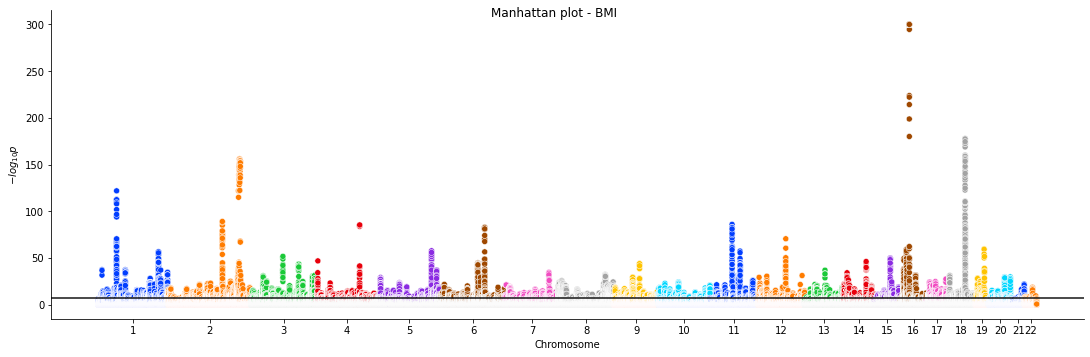

In [295]:
plot = sns.relplot(data = mh, x = 'i', y = 'logp_bmi', aspect=3, 
                   hue='chrom', palette = 'bright', legend=None) 
chrom_df=mh.groupby('chrom')['i'].median()
plot.ax.set_xlabel('Chromosome')
plot.ax.set_ylabel('$-log_{10}p$')
plot.ax.set_xticks(chrom_df)
plot.axes[0][0].axhline(y = -np.log10(5e-8), color='black', linewidth=2, alpha=.7)
plot.ax.set_xticklabels(chrom_df.index)
plot.fig.suptitle('Manhattan plot - BMI')

Text(0.5, 0.98, 'Manhattan plot - T2D')

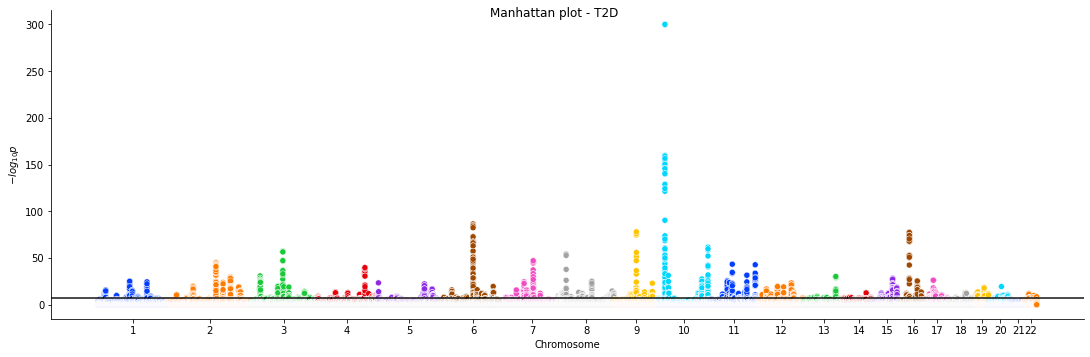

In [296]:
plot = sns.relplot(data=mh, x='i', y='logp_t2d', aspect=3, 
                   hue='chrom', palette = 'bright', legend=None) 
chrom_df = mh.groupby('chrom')['i'].median()
plot.ax.set_xlabel('Chromosome')
plot.ax.set_ylabel('$-log_{10}p$')
plot.ax.set_xticks(chrom_df)
plot.axes[0][0].axhline(y = -np.log10(5e-8), color='black', linewidth=2, alpha=.7)
plot.ax.set_xticklabels(chrom_df.index)
plot.fig.suptitle('Manhattan plot - T2D')

### 4. Assembly of obesity subtypes

- Selecting highly significant SNPs for both conditions ($p < 5 \cdot 10^{-8}$).
- Excluding:
    - Multi-allelic SNPs
    - INDELs
    - Ambiguous palindromic SNPs with minor allele frequency (MAF) > 40% [<sup>6</sup>](https://doi.org/10.7554/eLife.34408)
    - Rare SNPs (MAF < 1%)
- Harmonizing effects to the BMI increasing allele.
- Classifying SNPs as concordant or discordant.

In [441]:
sigdat = bmi_t2d.query('P_bmi < 5e-8 & Pvalue_t2d < 5e-8').assign(
    chrom = lambda x: x['CHR_bmi'],
    pos = lambda x: x['POS_bmi'],
    chrom_pos = lambda x: [snp.strip() for snp in x['SNP_t2d']],
    rsid = lambda x: x['SNP_bmi'],
    ea = lambda x: np.where(x['BETA_bmi'] > 0, x['Tested_Allele_bmi'], x['Other_Allele_bmi']),
    nea = lambda x: np.where(x['BETA_bmi'] > 0, x['Other_Allele_bmi'], x['Tested_Allele_bmi']),
    beta_bmi = lambda x: abs(x['BETA_bmi']),
    se_bmi = lambda x: x['SE_bmi'],
    p_bmi = lambda x: x['P_bmi'],
    n_bmi = lambda x: x['N_bmi'],
    eaf_bmi = lambda x: np.where(x['BETA_bmi'] > 0, x['Freq_Tested_Allele_in_HRS_bmi'],
                                 1 - x['Freq_Tested_Allele_in_HRS_bmi'])
).assign(
    ## This excludes possible multi-allelic SNPs
    harmon = lambda x: np.select([(x['EA_t2d'] == x['ea']) & (x['NEA_t2d'] == x['nea']),
                                  (x['EA_t2d'] == x['nea']) & (x['NEA_t2d'] == x['ea'])],
                                 [1, -1], default = 0)
).query('harmon != 0').assign(
    beta_t2d = lambda x: x['harmon'] * bmi_t2d['Beta_t2d'],
    se_t2d = lambda x: x['SE_t2d'],
    p_t2d = lambda x: x['Pvalue_t2d'],
    n_t2d = lambda x: x['Neff_t2d'],
    eaf_t2d = lambda x: np.where(x['harmon'] == 1, x['EAF_t2d'], 1 - x['EAF_t2d'])
).assign(
    ## This excludes palindromic SNPs with a minor allele frequency (MAF) > 0.4
    palind = lambda x: (((x['ea'] == 'A') & (x['nea'] == 'T')) |
                        ((x['ea'] == 'T') & (x['nea'] == 'A')) |
                        ((x['ea'] == 'C') & (x['nea'] == 'G')) |
                        ((x['ea'] == 'G') & (x['nea'] == 'C'))),
    maf_bmi = lambda x: np.where(x['eaf_bmi'] < 0.5, x['eaf_bmi'], 1 - x['eaf_bmi']),
    maf_t2d = lambda x: np.where(x['eaf_t2d'] < 0.5, x['eaf_t2d'], 1 - x['eaf_t2d']),
).assign(
    ambig = lambda x: x['palind'] & ((x['maf_bmi'] > 0.4) | (x['maf_t2d'] > 0.4)),
    indel = lambda x: (x['ea'].str.len() > 1) | (x['nea'].str.len() > 1),
    rare = lambda x: (x['maf_bmi'] < 0.01) | (x['maf_t2d'] < 0.01),
    ## Adding a column classifying discordant and concordant SNPs
    disc = lambda x: x['beta_t2d'] < 0
).query('~ (ambig | indel | rare)')[
    ['chrom', 'pos', 'chrom_pos', 'rsid', 'ea', 'nea', 
     'beta_bmi', 'se_bmi', 'p_bmi', 'n_bmi', 'eaf_bmi', 'maf_bmi',
     'beta_t2d', 'se_t2d', 'p_t2d', 'n_t2d', 'eaf_t2d', 'maf_t2d', 'disc']
].reset_index(drop = True)

In [442]:
sigdat

,chrom,pos,chrom_pos,rsid,ea,nea,beta_bmi,se_bmi,p_bmi,n_bmi,eaf_bmi,maf_bmi,beta_t2d,se_t2d,p_t2d,n_t2d,eaf_t2d,maf_t2d,disc
0,1,177793990,1:177793990,rs12735595,A,C,0.0338,0.0020,9.800000e-62,791691.0,0.1964,0.1964,0.046,0.0080,5.400000e-09,231420,0.20,0.20,False
1,1,177795017,1:177795017,rs4609391,T,C,0.0339,0.0020,3.800000e-62,792054.0,0.1965,0.1965,0.046,0.0080,5.000000e-09,231420,0.20,0.20,False
2,1,177798837,1:177798837,rs11586243,C,T,0.0338,0.0020,2.300000e-62,794385.0,0.1964,0.1964,0.047,0.0080,4.000000e-09,231420,0.20,0.20,False
3,1,177799888,1:177799888,rs4509539,C,T,0.0338,0.0020,2.200000e-62,794467.0,0.1964,0.1964,0.047,0.0080,4.300000e-09,231420,0.20,0.20,False
4,1,177802710,1:177802710,rs4132288,A,G,0.0339,0.0020,1.500000e-62,794283.0,0.1964,0.1964,0.047,0.0080,4.600000e-09,231420,0.20,0.20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,20,32687611,20:32687611,rs11696338,C,T,0.0132,0.0018,6.100000e-14,692550.0,0.6018,0.3982,0.038,0.0065,6.900000e-09,231420,0.60,0.40,False
1392,20,32698275,20:32698275,rs6087557,C,T,0.0110,0.0018,1.300000e-09,692337.0,0.6631,0.3369,0.042,0.0067,6.900000e-10,231420,0.67,0.33,False
1393,20,32700566,20:32700566,rs4911408,A,G,0.0108,0.0018,2.800000e-09,685723.0,0.6649,0.3351,0.042,0.0067,7.600000e-10,231420,0.67,0.33,False
1394,20,32709444,20:32709444,rs2223553,A,G,0.0117,0.0018,2.000000e-11,691112.0,0.5839,0.4161,0.037,0.0064,6.400000e-09,231420,0.59,0.41,False


### 5. Clumping using PLINK[<sup>7</sup>](https://www.cog-genomics.org/plink/) to obtain independent SNPs (not in linkage disequilibrium, i.e. correlated) 

5.1. Saving a table to be read by PLINK

In [326]:
pd.DataFrame({'SNP': sigdat['rsid'], 'P': sigdat['p_bmi']}).to_csv('to_plink.txt', sep = '\t', index = False)

5.2. Clumping with PLINK ($r^2$ < 0.01 over a 500 kb pair window)

In [327]:
!plink --bfile EUR --clump to_plink.txt --clump-p1 5e-8 --clump-kb 500 --clump-r2 0.01 --out plinkres

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plinkres.log.
Options in effect:
  --bfile EUR
  --clump to_plink.txt
  --clump-kb 500
  --clump-p1 5e-8
  --clump-r2 0.01
  --out plinkres

8192 MB RAM detected; reserving 4096 MB for main workspace.
8550156 variants loaded from .bim file.
503 people (0 males, 0 females, 503 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plinkres.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
8550156 variants and 503 people pass filters and QC.
Note: No phenotypes present.
8 more top variant IDs missing; see log file.
--clum

In [352]:
## Independent SNPs
!awk '{print $3}' plinkres.clumped > plinkres.txt
!head plinkres.txt

SNP
rs9936385
rs663129
rs13021737
rs543874
rs10938397
rs987237
rs2307111
rs7124681
rs17066842


In [353]:
## Calculating their MAF
!plink --bfile EUR --extract plinkres.txt --freq --out plinkfreq

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plinkfreq.log.
Options in effect:
  --bfile EUR
  --extract plinkres.txt
  --freq
  --out plinkfreq

8192 MB RAM detected; reserving 4096 MB for main workspace.
8550156 variants loaded from .bim file.
503 people (0 males, 0 females, 503 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plinkfreq.nosex .
--extract: 71 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
--freq: Allele frequencies (founders only) written to plinkfreq.frq .


In [413]:
## Importing
plinkres = pd.read_table('plinkfreq.frq', sep = '\s+', usecols = [1,4], header = 0, names = ['rsid', 'maf_eur'])
plinkres.head()

,rsid,maf_eur
0,rs2282231,0.1988
1,rs543874,0.1869
2,rs1538748,0.3638
3,rs13021737,0.1740
4,rs1260326,0.4105


In [443]:
## Selecting independent SNPs
sigdatc = pd.merge(sigdat, plinkres, on = 'rsid')
sigdatc.head()

,chrom,pos,chrom_pos,rsid,ea,nea,beta_bmi,se_bmi,p_bmi,n_bmi,eaf_bmi,maf_bmi,beta_t2d,se_t2d,p_t2d,n_t2d,eaf_t2d,maf_t2d,disc,maf_eur
0,1,177889480,1:177889480,rs543874,G,A,0.0475,0.0020,1.200000e-122,795504.0,0.1952,0.1952,0.051,0.0080,1.500000e-10,231420,0.20,0.20,False,0.1869
1,1,219623621,1:219623621,rs1538748,C,T,0.0094,0.0017,2.300000e-08,794936.0,0.3714,0.3714,-0.041,0.0065,2.500000e-10,231420,0.38,0.38,True,0.3638
2,1,39569571,1:39569571,rs2282231,T,C,0.0165,0.0021,4.800000e-15,689443.0,0.2249,0.2249,0.068,0.0076,7.800000e-19,231420,0.22,0.22,False,0.1988
3,2,147920213,2:147920213,rs7559658,C,T,0.0143,0.0022,6.100000e-11,691512.0,0.1893,0.1893,0.044,0.0081,3.500000e-08,231420,0.19,0.19,False,0.1958
4,2,161105876,2:161105876,rs10803762,A,G,0.0116,0.0018,3.500000e-10,686227.0,0.6781,0.3219,0.044,0.0068,1.600000e-10,231420,0.68,0.32,False,0.3221


### 5. Ensuring SNP congruency by comparing minor allele frequencies

5.1. Comparing MAF between the reference panel and the two studies.

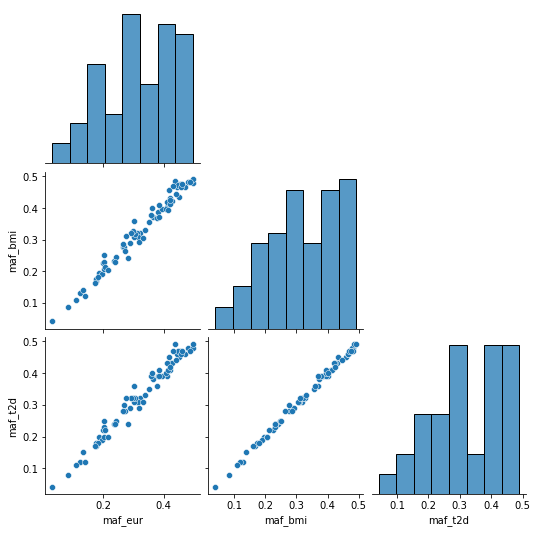

In [469]:
sns.pairplot(sigdatc[['maf_eur', 'maf_bmi', 'maf_t2d']], corner = True)

### 6. Visualizing obesity subtypes

6.1. Plotting coefficients for BMI vs coefficients for T2D

Text(0.065, -0.03, 'Discordant')

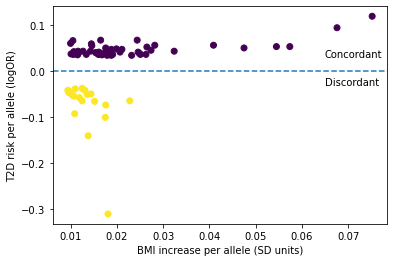

In [438]:
plt.scatter(sigdatc['beta_bmi'], sigdatc['beta_t2d'], c = sigdatc['disc'])
plt.xlabel('BMI increase per allele (SD units)')
plt.ylabel('T2D risk per allele (logOR)')
plt.axhline(ls = "--")
plt.annotate('Concordant', xy = (0.065, 0.03))
plt.annotate('Discordant', xy = (0.065, -0.03))

### 7. Associations of obesity subtypes with blood biomarkers in UK Biobank [<sup>8</sup>](https://www.ukbiobank.ac.uk/)

Genome-wide association analyses results performed by the Neale Lab [<sup>9</sup>](http://www.nealelab.is/uk-biobank)

7.1. Available biomarkers with links to result tables (extracted from the analysis [Google sheet](https://docs.google.com/spreadsheets/d/1kvPoupSzsSFBNSztMzl04xMoSC3Kcx3CrjVf4yBmESU/edit?ts=5b5f17db#gid=178908679))

In [557]:
sheet_id = '1kvPoupSzsSFBNSztMzl04xMoSC3Kcx3CrjVf4yBmESU'
gid = '178908679'

bm_avail = pd.read_table(
    'https://broad-ukb-sumstats-us-east-1.s3.amazonaws.com/round2/annotations/' +
    'biomarkers.both_sexes.tsv.bgz', compression = 'gzip', usecols = range(5)
).query(
    ## Selecting analyses with inverse-normalized phenotypes
    'variable_type == "continuous_irnt"'
)

bm_links = pd.read_table(
    'https://docs.google.com/spreadsheets/d/' + sheet_id + '/export?format=tsv' + '&gid=' + gid,
    usecols = [0,1,3,6], header = 0, names = ['phenotype', 'description', 'sex', 'link']
).query('sex == "both_sexes"')

bm_list = pd.merge(bm_avail, bm_links).assign(
    description = lambda x: x['description'].str.replace('\(quantile\)', '', regex = True)
).rename(columns = {'n_non_missing':'n_trait'})[['description', 'n_trait', 'link']]

bm_list

,description,n_trait,link
0,Albumin,315268,https://broad-ukb-sumstats-us-east-1.s3.amazon...
1,Alkaline phosphatase,344292,https://broad-ukb-sumstats-us-east-1.s3.amazon...
2,Alanine aminotransferase,344136,https://broad-ukb-sumstats-us-east-1.s3.amazon...
3,Apoliprotein A,313387,https://broad-ukb-sumstats-us-east-1.s3.amazon...
4,Apoliprotein B,342590,https://broad-ukb-sumstats-us-east-1.s3.amazon...
5,Aspartate aminotransferase,342990,https://broad-ukb-sumstats-us-east-1.s3.amazon...
6,Direct bilirubin,292933,https://broad-ukb-sumstats-us-east-1.s3.amazon...
7,Urea,344052,https://broad-ukb-sumstats-us-east-1.s3.amazon...
8,Calcium,315153,https://broad-ukb-sumstats-us-east-1.s3.amazon...
9,Cholesterol,344278,https://broad-ukb-sumstats-us-east-1.s3.amazon...


7.2. Available SNPs (all SNPs are in the same order in all biomarker results)

In [559]:
ukbsnps_url = bm_list['link'][0]
ukbsnps = pd.read_table(
    ukbsnps_url, compression = 'gzip', usecols = [0], header = 0,
    names = ['chrom_pos'], dtype = {'chrom_pos': object}
).reset_index()
ukbsnps['chrom_pos'] = ukbsnps['chrom_pos'].str.replace(r':[A-Z]+:[A-Z]+', '', regex = True)
ukbsnps.head()

,index,chrom_pos
0,0,10:10000018
1,1,10:100000625
2,2,10:100000645
3,3,10:100000984
4,4,10:100001724


7.3. Indexing SNPs needed

In [560]:
toextract = ukbsnps.merge(sigdatc[['chrom_pos']])
toextract.head()

,index,chrom_pos
0,79306,10:114758349
1,644140,10:93810872
2,892988,11:17394073
3,920069,11:2204717
4,1045262,11:43825038


In [561]:
rowind = toextract['index'].values.tolist()
## This will be used in the sed command to extract the associations needed
rowsed = 'p;'.join(str(i + 2) for i in rowind) + 'p;' + str(max(rowind) + 3) + 'q'

In [562]:
rowsed

'79308p;644142p;892990p;920071p;1045264p;1064734p;1148352p;1187708p;2128791p;2255955p;2258027p;2478226p;2556465p;2785590p;3038827p;3116063p;3155324p;3366879p;3370694p;3424937p;3516882p;3855868p;3946182p;4047906p;4167169p;4279898p;4285853p;4286776p;4303361p;4479060p;4614287p;4618911p;4627221p;5005055p;5229371p;5467568p;5886315p;6371873p;6679972p;6748155p;6768130p;7195783p;7389524p;7391133p;7411189p;7690552p;7694065p;7947188p;8266833p;8347550p;8546772p;8730118p;9198888p;9461408p;9689117p;10129296p;10236352p;10689490p;10774749p;10950608p;10989091p;11274587p;11414905p;11655800p;12080578p;12114786p;12412960p;12693317p;12724740p;12772108p;13111963p;13111964q'

7.4. Function to iterate over the links to extract the associations needed

In [564]:
def downloadukb (dat_url, dat_trait):
    "Function to download UKB summary statistics for just the variants needed"
    resdat = !curl -s "$dat_url" | gunzip -c | sed -n "$rowsed" | cut -f1,4,8,9,10,11
    resdf = pd.DataFrame([re.split(':|\t', l) for l in resdat],
                         columns = ['chrom', 'pos', 'nea_trait', 'ea_trait', 'lowconf', 
                                    'beta_trait', 'se_trait', 'z_trait', 'p_trait'])
    print(dat_trait + " done.")
    return resdf.assign(trait = dat_trait)

7.5. Extracting the associations

In [565]:
bm_res = bm_list.apply(lambda x: downloadukb(x['link'], x['description']), axis = 1)

Albumin  done.
Alkaline phosphatase  done.
Alanine aminotransferase  done.
Apoliprotein A  done.
Apoliprotein B  done.
Aspartate aminotransferase  done.
Direct bilirubin  done.
Urea  done.
Calcium  done.
Cholesterol  done.
Creatinine  done.
C-reactive protein  done.
Cystatin C  done.
Gamma glutamyltransferase  done.
Glucose  done.
Glycated haemoglobin  done.
HDL cholesterol  done.
IGF-1  done.
LDL direct  done.
Lipoprotein A  done.
Oestradiol  done.
Phosphate  done.
Rheumatoid factor  done.
SHBG  done.
Total bilirubin  done.
Testosterone  done.
Total protein  done.
Triglycerides  done.
Urate  done.
Vitamin D  done.
Estimated sample dilution factor  done.


7.6. Harmonizing associations to the BMI increasing allele

In [596]:
bm_scan = pd.concat(
    [result for result in bm_res], ignore_index=True
).assign(
    trait = lambda x: x['trait'].str.replace(r'\(quantile\)', '', regex=True),
    chrom_pos = lambda x: [str(snp).strip() for snp in (x['chrom'] + ":" + x['pos'])],
    beta_trait = lambda x: pd.to_numeric(x['beta_trait']),
    se_trait = lambda x: pd.to_numeric(x['se_trait']), 
    z_trait = lambda x: pd.to_numeric(x['z_trait']), 
    p_trait = lambda x: pd.to_numeric(x['p_trait'])
).drop(
    ['chrom', 'pos'], axis = 1
).merge(
    bm_list.rename(columns = {'description' : 'trait'})[['trait', 'n_trait']]
).merge(
    sigdatc
).assign(
    harmon = lambda x: np.select([(x['ea_trait'] == x['ea']) & (x['nea_trait'] == x['nea']),
                                  (x['ea_trait'] == x['nea']) & (x['nea_trait'] == x['ea'])],
                                 [1, -1], default = 0)
).query('harmon != 0').assign(
    beta_trait = lambda x: x['beta_trait'] * x['harmon'],
    z_trait = lambda x: x['z_trait'] * x['harmon']
).drop('harmon', axis = 1)
bm_scan

,nea_trait,ea_trait,lowconf,beta_trait,se_trait,z_trait,p_trait,trait,chrom_pos,n_trait,...,eaf_bmi,maf_bmi,beta_t2d,se_t2d,p_t2d,n_t2d,eaf_t2d,maf_t2d,disc,maf_eur
0,C,T,false,-0.016702,0.002709,-6.16650,6.990900e-10,Albumin,10:114758349,315268,...,0.7088,0.2912,-0.310,0.0069,0.000000e+00,231420,0.71,0.29,True,0.3171
1,C,T,false,0.003985,0.002561,1.55590,1.197200e-01,Alkaline phosphatase,10:114758349,344292,...,0.7088,0.2912,-0.310,0.0069,0.000000e+00,231420,0.71,0.29,True,0.3171
2,C,T,false,-0.006059,0.002459,-2.46400,1.374200e-02,Alanine aminotransferase,10:114758349,344136,...,0.7088,0.2912,-0.310,0.0069,0.000000e+00,231420,0.71,0.29,True,0.3171
3,C,T,false,0.004242,0.002548,1.66460,9.599100e-02,Apoliprotein A,10:114758349,313387,...,0.7088,0.2912,-0.310,0.0069,0.000000e+00,231420,0.71,0.29,True,0.3171
4,C,T,false,0.011793,0.002612,4.51490,6.336300e-06,Apoliprotein B,10:114758349,342590,...,0.7088,0.2912,-0.310,0.0069,0.000000e+00,231420,0.71,0.29,True,0.3171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,G,C,false,-0.001928,0.002680,-0.71935,4.719300e-01,Total protein,9:28410996,314921,...,0.3175,0.3175,0.042,0.0068,1.100000e-09,231420,0.32,0.32,False,0.3052
2197,G,C,false,0.005415,0.002474,2.18840,2.864300e-02,Triglycerides,9:28410996,343992,...,0.3175,0.3175,0.042,0.0068,1.100000e-09,231420,0.32,0.32,False,0.3052
2198,G,C,false,0.005350,0.002168,2.46720,1.361900e-02,Urate,9:28410996,343836,...,0.3175,0.3175,0.042,0.0068,1.100000e-09,231420,0.32,0.32,False,0.3052
2199,G,C,false,-0.007609,0.002612,-2.91290,3.580600e-03,Vitamin D,9:28410996,329247,...,0.3175,0.3175,0.042,0.0068,1.100000e-09,231420,0.32,0.32,False,0.3052


### 8. Comparing associations of each subtype in a heatmap

Text(780.4999999999999, 0.5, 'Obesity subtype - SNPs')

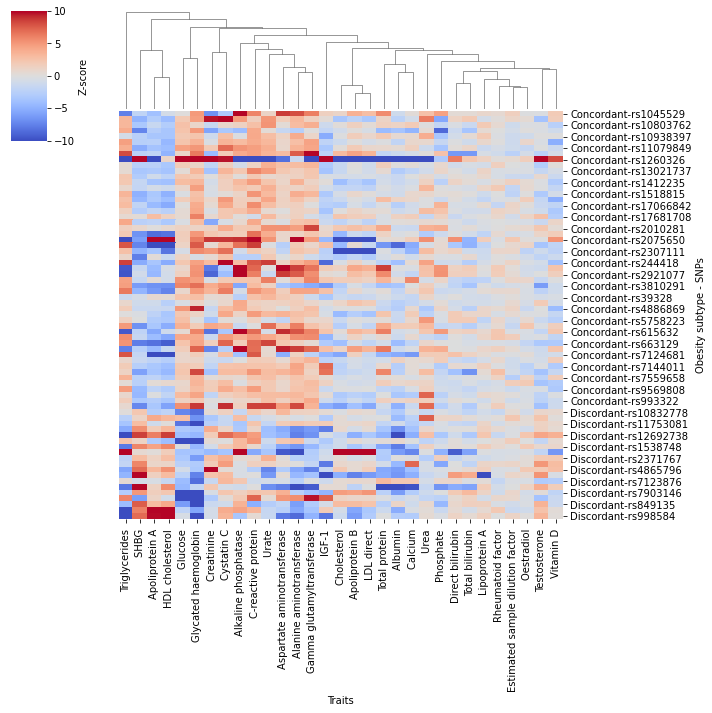

In [597]:
hmdat = bm_scan.assign(
    z_trait = lambda x: np.where(abs(x['z_trait']) > 10, 
                                 np.sign(x['z_trait'])*10, 
                                 x['z_trait']),
    disc = lambda x: np.where(x['disc'], 'Discordant', 'Concordant')
).pivot_table(
    index = ['disc', 'rsid'], columns = 'trait', values = 'z_trait'
)
hmplot = sns.clustermap(hmdat, row_cluster = False, 
                        method = 'average', metric = 'euclidean',
                        cmap = 'coolwarm', cbar_kws={'label': 'Z-score'})
hmplot.ax_heatmap.set_xlabel("Traits")
hmplot.ax_heatmap.set_ylabel("Obesity subtype - SNPs")

In [598]:
hmplot.savefig('hmplot.png')